# 3. Plant-Level Analysis

This is the main analysis notebook. Here, we will loop through every unique plant and fit the growth models to its specific data.

The workflow is as follows:
1.  Load the full dataset.
2.  Load the scaler object and global parameters we saved from Notebook 02.
3.  Apply the saved scaling to the entire dataset.
4.  Loop through each plant:
    - Fit the five primary growth models (Linear, Ricker, Logistic, Exponential, Gen. VB).
    - Use the global parameters as the initial guess for the optimization.
    - Calculate AIC, R², and Adjusted R² for each fit.
5.  Store all results in a single DataFrame.
6.  Save the final results to a `.csv` file.

## 3.1 Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm # For a progress bar
from sklearn.preprocessing import MinMaxScaler 

# Add the parent directory to the system path to allow imports from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import all our custom functions
from src.data_processing import load_data, preprocess_data
from src.models import linear, ricker_model, logistic_fun, exponential, gen_vb
from src.fitting import (cost_linear, cost_ricker, cost_logistic, cost_exponential, cost_gvb,
                         AIC_linear, AIC_ricker, AIC_logistic, AIC_exp, AIC_gen_vb)
from src.analysis import r2_adjusted, calculate_aic_weights
from src.visualization import plot_growth_models

# Set plot styles
%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

## 3.2 Load Data and Saved Objects

We load the raw data, the fitted scaler, and the global optimal parameters.

In [2]:
# --- Load Raw Data ---
FEATURES_PATH = '../data/5.25.2024_CBI.0010_York_Poplar_RGB.side_features.csv'
BARCODE_PATH = '../data/barcodes--5.25.2024_CBI.0010_York_Poplar.csv'
data_df, barcode_df = load_data(FEATURES_PATH, BARCODE_PATH)
merged_df = preprocess_data(data_df, barcode_df, experiment_start_str='2024-05-26 00:00:00')
print(f"Loaded and processed {merged_df.shape[0]} data points.")

# --- Load Scaler, Params, and the EXACT Column List ---
SCALER_PATH = '../results/data/global_minmax_scaler.joblib'
PARAMS_PATH = '../results/data/global_optimal_params.joblib'
COLUMNS_PATH = '../results/data/scaled_columns_list.joblib' # <-- Use the new file

scaler_obj = joblib.load(SCALER_PATH)
global_params = joblib.load(PARAMS_PATH)
columns_to_scale = joblib.load(COLUMNS_PATH) # <-- Load the exact list

print(f"Scaler loaded from: {SCALER_PATH}")
print(f"List of {len(columns_to_scale)} columns to scale loaded from: {COLUMNS_PATH}")
print("Global parameters loaded successfully.")

Loaded and processed 3407 data points.
Scaler loaded from: ../results/data/global_minmax_scaler.joblib
List of 50 columns to scale loaded from: ../results/data/scaled_columns_list.joblib
Global parameters loaded successfully.


## 3.4 Main Analysis Loop

This is the core of the analysis. We'll loop through each plant, fit the models, and store the results. We use `tqdm` to create a progress bar, which is helpful for long-running loops.

In [3]:
# Get initial guesses from the global parameters
q0_linear = global_params['linear']
q0_logistic = global_params['logistic']
q0_ricker = global_params['ricker']
q0_exp = global_params['exponential']
q0_gvb = global_params['gen_vb']

# Define the parameter bounds
bounds_linear = ((0, 1), (0, 1))
bounds_logistic = ((0, 1), (0, 1), (0, 1.5))
bounds_ricker = ((0, 1), (0, 1), (0, 1.5))
bounds_exp = ((0, 1), (0, 1))
bounds_gvb = ((0, 5), (0.01, 2), (0.01, 0.99), (0.8, 1.5))

# --- Main Loop ---
results_list = []
# Use the unscaled merged_df to get the list of plants
unique_plants = merged_df['Plant Info'].unique()

for plant_id in tqdm(unique_plants, desc="Fitting models to plants"):
    # Use the unscaled dataframe and create a copy to avoid warnings
    plant_data = merged_df[merged_df['Plant Info'] == plant_id].copy()
    
    if len(plant_data) < 5:
        continue

    # Scale the 'area' for this specific plant to the [0, 1] range
    scaler = MinMaxScaler()
    plant_data['area_scaled'] = scaler.fit_transform(plant_data[['area']])

    dd = plant_data["Days_Since_2024_05_26"].to_numpy()
    area = plant_data["area_scaled"].to_numpy()

    result_row = {'Plant Info': plant_id, 
                  'Plant Genotype': plant_data['Plant.Genotype'].iloc[0]}

    # --- Fit Models ---
    # 1. Linear
    lin_opt = minimize(cost_linear, q0_linear, args=(dd, area), method='L-BFGS-B', bounds=bounds_linear)
    pred_lin = linear(dd, lin_opt.x)
    result_row['m0_optimal_linear'], result_row['k_optimal_linear'] = lin_opt.x
    result_row['Cost_Linear'] = lin_opt.fun
    result_row['AIC_Linear'] = AIC_linear(lin_opt.x, dd, area)
    result_row['R2_Linear'] = r2_score(area, pred_lin)
    result_row['R2_adj_Linear'] = r2_adjusted(result_row['R2_Linear'], len(dd), 2)

    # 2. Ricker
    ricker_opt = minimize(cost_ricker, q0_ricker, args=(dd, area), method='L-BFGS-B', bounds=bounds_ricker)
    pred_ricker = ricker_model(dd, ricker_opt.x)
    result_row['W0_optimal_ricker'], result_row['kg_optimal_ricker'], result_row['m_optimal_ricker'] = ricker_opt.x
    result_row['Cost_Ricker'] = ricker_opt.fun
    result_row['AIC_Ricker'] = AIC_ricker(ricker_opt.x, dd, area)
    result_row['R2_Ricker'] = r2_score(area, pred_ricker)
    result_row['R2_adj_Ricker'] = r2_adjusted(result_row['R2_Ricker'], len(dd), 3)

    # 3. Logistic
    log_opt = minimize(cost_logistic, q0_logistic, args=(dd, area), method='L-BFGS-B', bounds=bounds_logistic)
    pred_log = logistic_fun(dd, log_opt.x)
    result_row['P0_optimal_log'], result_row['r_optimal_log'], result_row['K_optimal_log'] = log_opt.x
    result_row['Cost_Logistic'] = log_opt.fun
    result_row['AIC_Logistic'] = AIC_logistic(log_opt.x, dd, area)
    result_row['R2_Logistic'] = r2_score(area, pred_log)
    result_row['R2_adj_Logistic'] = r2_adjusted(result_row['R2_Logistic'], len(dd), 3)

    # 4. Exponential
    exp_opt = minimize(cost_exponential, q0_exp, args=(dd, area), method='L-BFGS-B', bounds=bounds_exp)
    pred_exp = exponential(dd, exp_opt.x)
    result_row['m0_optimal_exp'], result_row['k_optimal_exp'] = exp_opt.x
    result_row['Cost_Exponential'] = exp_opt.fun
    result_row['AIC_Exponential'] = AIC_exp(exp_opt.x, dd, area)
    result_row['R2_Exponential'] = r2_score(area, pred_exp)
    result_row['R2_adj_Exponential'] = r2_adjusted(result_row['R2_Exponential'], len(dd), 2)

    # 5. Gen. VB
    gvb_opt = minimize(cost_gvb, q0_gvb, args=(dd, area), method='L-BFGS-B', bounds=bounds_gvb)
    pred_gvb = gen_vb(dd, gvb_opt.x)
    result_row['m0_optimal_gvb'], result_row['k_optimal_gvb'], result_row['f_optimal_gvb'], result_row['A_optimal_gvb'] = gvb_opt.x
    result_row['Cost_Gen_VB'] = gvb_opt.fun
    result_row['AIC_Gen_VB'] = AIC_gen_vb(gvb_opt.x, dd, area)
    result_row['R2_Gen_VB'] = r2_score(area, pred_gvb)
    result_row['R2_adj_Gen_VB'] = r2_adjusted(result_row['R2_Gen_VB'], len(dd), 4)
    
    results_list.append(result_row)

print("Finished fitting models to all plants.")

Fitting models to plants:   0%|          | 0/446 [00:00<?, ?it/s]

c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  P = K/(((K - P0)/P0)*np.exp(-r*t) + 1)
c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  P = K/(((K - P0)/P0)*np.exp(-r*t) + 1)
c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  P = K/(((K - P0)/P0)*np.exp(-r*t) + 1)
c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  P = K/(((K - P0)/P0)*np.exp(-r*t) + 1)
c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: invalid value encountered in divide
  P = K/(

Finished fitting models to all plants.


c:\Users\katie\OneDrive - East Tennessee State University\School\Data-Saplings-Organized\src\models.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  P = K/(((K - P0)/P0)*np.exp(-r*t) + 1)


## 3.5 Create and Save Results DataFrame

Now we convert our list of results into a DataFrame, calculate the AIC weights to determine the best-fitting model for each plant, and save it all to a file.

In [4]:
# Create DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Calculate AIC weights to compare models
results_df = calculate_aic_weights(results_df)

# Save the results to a CSV file
RESULTS_SAVE_PATH = '../results/data/all_plant_model_results.csv'
results_df.to_csv(RESULTS_SAVE_PATH, index=False)

print(f"Results table shape: {results_df.shape}")
print(f"Results saved to: {RESULTS_SAVE_PATH}")
results_df.head()

Results table shape: (446, 41)
Results saved to: ../results/data/all_plant_model_results.csv


,Plant Info,Plant Genotype,m0_optimal_linear,k_optimal_linear,Cost_Linear,AIC_Linear,R2_Linear,R2_adj_Linear,W0_optimal_ricker,kg_optimal_ricker,...,A_optimal_gvb,Cost_Gen_VB,AIC_Gen_VB,R2_Gen_VB,R2_adj_Gen_VB,Linear_AIC_Weight,Ricker_AIC_Weight,Logistic_AIC_Weight,Exponential_AIC_Weight,Gen_VB_AIC_Weight
0,22_BESC-1126_2,BESC-1126,0.000000,0.032305,0.004043,-34.085887,9.699482e-01,0.957927,0.210486,0.070950,...,0.938109,0.000304,-39.776709,0.997737,0.994720,0.016849,1.689401e-07,0.693148,0.000058,0.289945
1,23_BESC-1207_2,BESC-1207,0.284176,0.000000,0.103168,-5.099760,-2.220446e-16,-0.500000,0.284176,0.000000,...,0.800000,0.103792,14.142418,-0.006044,-2.018131,0.486686,1.329807e-02,0.013298,0.486686,0.000032
2,24_BESC-317_2,BESC-317,0.000000,0.029134,0.005413,-31.751534,9.542177e-01,0.935905,0.194432,0.065742,...,0.919042,0.002505,-22.915341,0.978812,0.950562,0.679131,1.884795e-05,0.198567,0.114095,0.008188
3,25_GW-9919_3,GW-9919,0.000000,0.034356,0.003572,-35.077977,9.726055e-01,0.961648,0.225741,0.071977,...,0.987899,0.001479,-27.128717,0.988652,0.973522,0.117337,2.008635e-06,0.880229,0.000227,0.002204
4,26_BESC-1068_5,BESC-1068,0.000000,0.025446,0.016021,-23.070858,8.671459e-01,0.814004,0.171145,0.060512,...,0.941606,0.000146,-45.631095,0.998786,0.997166,0.000007,3.699288e-09,0.407160,0.001804,0.591029


## 3.6 Visualize a Sample Result

Let's pick one plant and plot its data and all the model fits to make sure the process worked as expected. The legend includes the AIC Weight (W), which tells you the probability that a given model is the best fit among the options.

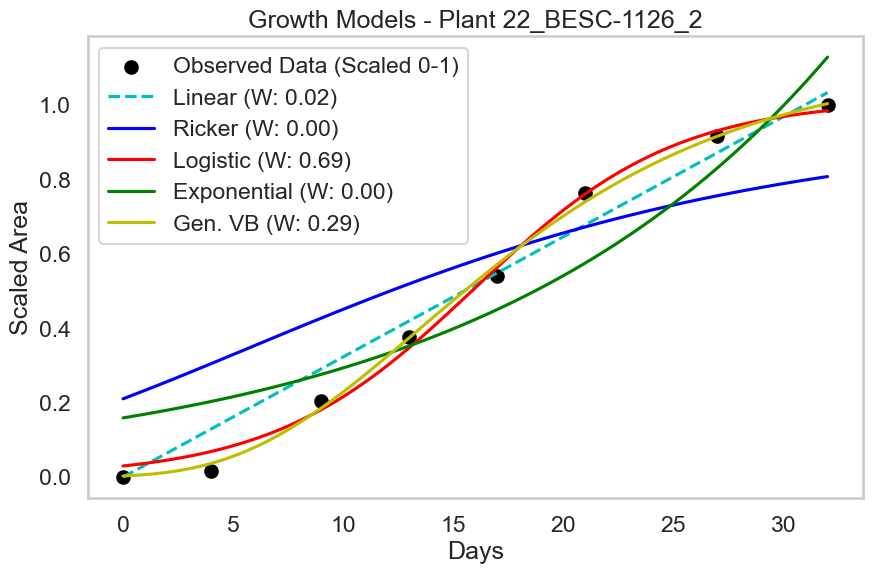

In [ ]:
# Choose a plant to plot (e.g., the first one in our results)
sample_plant_id = results_df['Plant Info'].iloc[0]

plot_growth_models(plant_id=sample_plant_id, dat=merged_df, results_df=results_df)

## 3.7 Next Steps

We have successfully fit all models to all plants and saved the comprehensive results. The final step is to analyze these results to find patterns and answer our research questions.

**Next step:** `04_statistical_analysis.ipynb`